In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HHG import HighHarmonicGeneration
from matplotlib.colors import LogNorm

### HHG examples
In this notebook we will have a look at the functionality of the HHG class and how to use it to calculate HHG spectra among other things.

As is stands, there is only the possibility to choose a linear field with a $\sin^2$-envelope of the form
$$
    \mathbf{A}(t) = 2\sqrt{U_\text{p}}\cos(\omega t + \varphi)\sin^2\left(\frac{\omega t}{2 N_\text{cycles}}\right) \hat{\mathbf{e}}_z,
$$
where $\omega$ is the carrier frequency, $\varphi$ is the carrier envelope phase (CEP) and $N_\text{cycles}$ is the number of cycles.

Now, to perform any calculations, the first step is to create a dictionary with the necessary information. Such an example is presented in the cell below:


In [2]:
settings_dict = {
    'Ip': 0.5,              # Ionization potential (a.u.)
    'Wavelength': 800,      # (nm)
    'Intensity': 2e14,      # (W/cm^2)
    'cep': np.pi/2,         # Carrier envelope phase
    'N_cycles': 10,          # Nr of cycles
    'N_cores': 4,           # Nr of cores to use in the multiprocessing calculations
    'SPA_time_integral': True
}

# Create an instance of the HHG class with the settings as the parameter
HHG = HighHarmonicGeneration(settings_dict)

### Finding the saddle points
As in the ATI example notebook, we must first determine the saddle points, which is done in the following cell
When running the cell, a plot will pop up where you must click at the saddle points, which are white 'dots' here.
Subsequently, once all saddle points have been marked, click the arrow pointing to the right, which should be visible while hovering you mouse over the plot.
Don't worry about getting it *exactly* on point, a root finder will do the rest of the hard work! Just make sure that it is close. Otherwise, the root finder may end up diverging and terminating at some unfavourable point, which eventually lead to undesirabl results. 


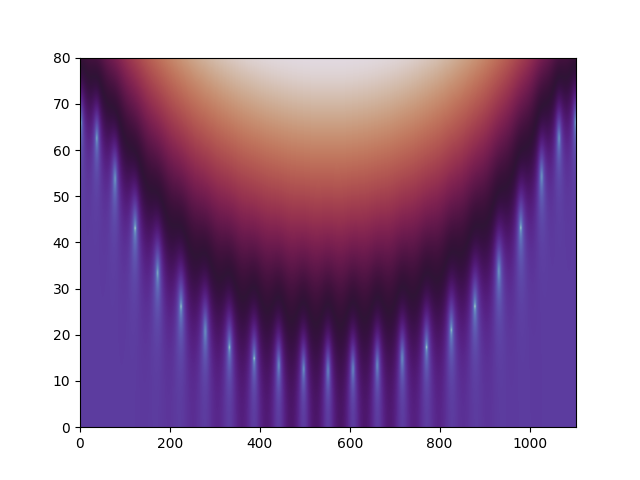

In [3]:
# Here, PyQt5 or PyQt6 is required! If it does not work with 'widget' try 'qt' instead
# This will allow you to simply click on the saddle points.
%matplotlib widget

# Prompt the plot to find the saddle points
HHG.get_saddle_guess([0, HHG.period],   # The interval in Re[t] to be displayed
                     [0, 80],           # The interval in Im[t] to be displayed
                     400,               # The number of grid points on the real time axis
                     400)               # The number of grid points on the imaginary time axis

# Save the guesses for later (so you don't have to click it all again!)
np.save('test_guess', HHG.guess_saddle_points)
#plt.show()
# Loads saddle points into the class
#HHG.guess_saddle_points = np.load('test_guess.npy')

### Make a HHG spectrum
With the saddle points now at hand, we can finally calculate the HHG spectrum!


In [4]:
np.save('test_guess.npy', HHG.guess_saddle_points) # Save the saddle points for later

In [5]:
# Print to make sure they look all right
HHG.guess_saddle_points = np.load('test_guess.npy')
HHG.guess_saddle_points

array([  31.13871689+61.51515152j,   75.62259816+52.85714286j,
        122.3306735 +42.9004329j ,  169.03874884+32.94372294j,
        224.64360043+25.36796537j,  280.24845202+19.95670996j,
        335.85330361+17.14285714j,  387.00976707+14.54545455j,
        438.16623054+12.5974026j ,  500.44366432+12.38095238j,
        553.82432185+11.94805195j,  609.42917344+12.38095238j,
        660.5856369 +13.03030303j,  718.41468256+14.11255411j,
        767.34695196+17.14285714j,  827.40019168+20.38961039j,
        880.7808492 +25.8008658j ,  929.7131186 +33.59307359j,
        978.645388  +42.25108225j, 1023.12926928+53.50649351j,
       1067.61315055+60.86580087j])

Now, before calculating the HHG spectrum, we must obtain the dipole as a function of the recombination times. The times and dipole values ae then saved as member variables in the HHG class such that we only need to calulate it once. It takes *some* minutes depedning on the length of the pulse. For a 8-cycle pulse, expect around 7-10 minutes or so.

In [6]:
HHG.get_dipole()

(array([0.00000000e+00, 2.20644464e-02, 4.41288928e-02, ...,
        1.10315613e+03, 1.10317819e+03, 1.10320026e+03]),
 array([6.85621876e-07+0.j, 6.82589425e-07+0.j, 6.79472281e-07+0.j, ...,
        6.79472281e-07+0.j, 6.82589425e-07+0.j, 6.85621876e-07+0.j]))

Now we can calculate the HHG spectrum!

In [7]:
# This makes sure that things again are plotted properly in the notebook! (We revert from the qt or widget setting to the default)
%matplotlib inline

# Calculate the HHG spectrum
signal, frequency = HHG.calculate_HHG_spectrum()

Now calculating the spectrum!


Now make a nice plot:

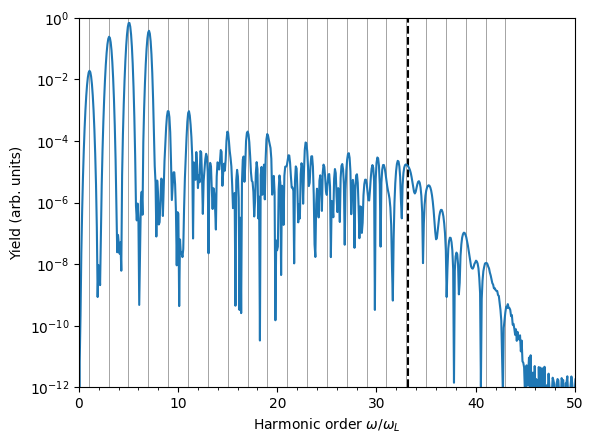

In [8]:
# Filter out negatve frequencies from the fast Fourier transform
frequency_mask = frequency >= 0
signal = signal[frequency_mask]
frequency = frequency[frequency_mask]

## Plot!

# Make a black line at the high harmonic cutoff frequency
plt.axvline((HHG.Ip + 3.17 * HHG.Up) / HHG.omega, ls='--', c='black')

# Plot some small vertical lines at odd harmonic orders
for i in range(1, 45, 2):
    plt.axvline(i, zorder=-1, lw=0.5, color='grey')

plt.plot(frequency / HHG.omega, frequency**2 * np.abs(signal)**2)
plt.xlabel(r'Harmonic order $\omega/\omega_L$')
plt.ylabel(r'Yield (arb. units)')
plt.xlim(0, 50)
plt.ylim(1e-12, 1)
plt.yscale('log')
plt.minorticks_on()

plt.show()

So there we see a prime example of a HHG spectrum.  

### Time-frequency analysis
A common tool when dealing with HHG is he so-called Gabor transform. Given a time-series signal, here the dipole acceleeration $\ddot{d}(t)$, it is defined by
$$
    G_\tau[\ddot{d}](t,\omega) = \int_{-\infty}^\infty\mathrm{d}t' \mathrm{e}^{-\mathrm{i}\omega t'}\mathrm{e}^{-\frac{(t-t')^2}{2\tau^2}}\ddot{d}(t'),
$$
where $\omega$ is the frequency (or energy, $\hbar=1$) and $\tau$ is the width of the Gaussian. It is also called a 'sliding window Fourier transform', and it allows for wiewing time series signals in both time and space at once.

Let's have a look at the dipole first

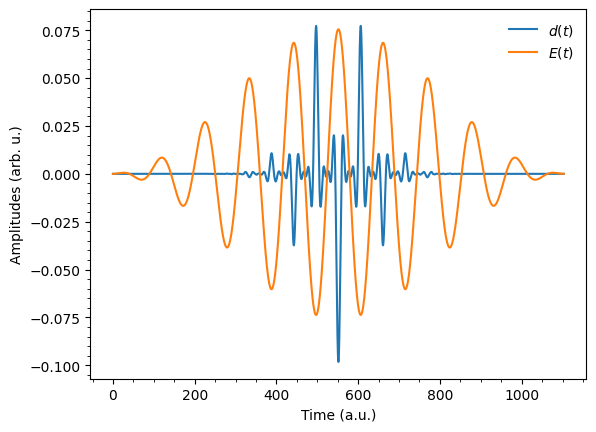

In [9]:
plt.plot(HHG.t_recomb, np.real(HHG.dipole), label=r'$d(t)$')
plt.plot(HHG.t_recomb, HHG.E_field_sin2(HHG.t_recomb), label=r'$E(t)$')
plt.xlabel('Time (a.u.)')
plt.ylabel('Amplitudes (arb. u.)')
plt.minorticks_on()
plt.legend(frameon=False)

In [10]:
G, ts, ws = HHG.get_spectrogram(
    2*np.pi,            # Width of the Gaussian 
    50,                 # Integer! Takes every Nth entry in the time and dipole lists - about 50 seems to be converged
    45,                 # Maximum harmonic order
    120)                # Number of grid points in energy

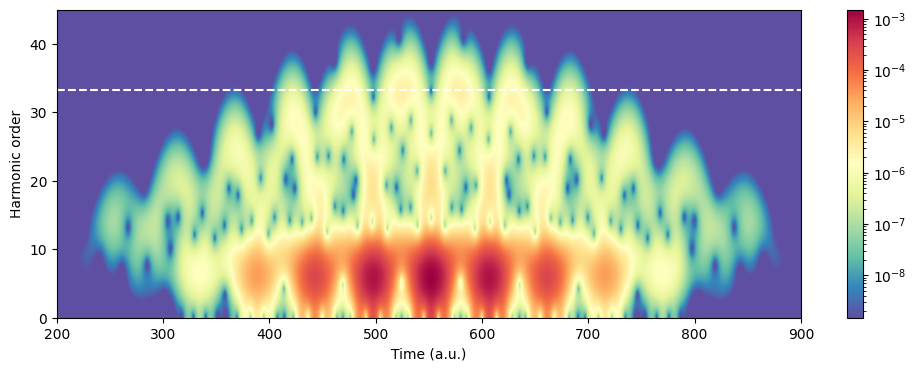

In [11]:
M = np.abs(G)**2
M_max = np.max(M)
vmin, vmax = M_max*1e-6, M_max
M[M < vmin] = vmin

plt.figure(figsize=(12, 4))

plt.imshow(np.flip(M.T, 0), extent=(ts[0], ts[-1], ws[0]/HHG.omega, ws[-1]/HHG.omega),
            aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax), interpolation='bicubic',
            cmap='Spectral_r')
plt.colorbar()

plt.axhline((HHG.Ip + 3.17*HHG.Up)/HHG.omega, ls='--', color='white')
plt.xlabel('Time (a.u.)')
plt.ylabel('Harmonic order')
plt.xlim(200, 900)
plt.show()